# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## Importiamo i dataset

In [1]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"unzip" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


# Importing libraries

In [2]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import gensim
import seaborn as sns
import numpy as np
import wordcloud
import pickle
import string
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora,models
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

C:\Users\Giacomo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giacomo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giacomo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Giacomo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Reading and analyzing true news
df_true = pd.read_csv("True.csv")
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [4]:
df_true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [5]:
#Reading and analyzing fake news
df_fake = pd.read_csv("Fake.csv")
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
df_fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

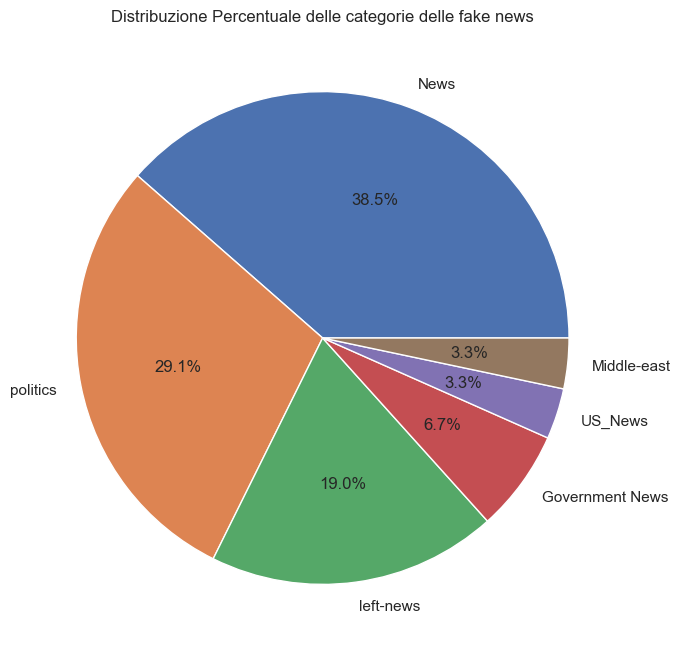

In [7]:
#calculation of the percentage of fake news subjects
subject_counts = df_fake['subject'].value_counts(normalize=True) * 100

#Creation of the pie chart of the percentages of fake news subjects
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%')
plt.title('Distribuzione Percentuale delle categorie delle fake news')
plt.show()

Il grafico a torta rappresenta la distribuzione percentuale delle diverse categorie di fake news. Dall'analisi dei dati emerge che le fake news sono maggiormente concentrate nelle seguenti categorie:
- News Generali (38,5%): Questa è la categoria più ampia, comprendente più di 1/3 delle fake news. Indica che molte notizie false si presentano come notizie generiche, spesso difficili da catalogare in una specifica sottocategoria.

- Politica (29,1%): Con quasi il 30%, la politica è la seconda categoria più prevalente. Questo riflette l'alto livello di disinformazione in ambito politico, probabilmente legata a campagne elettorali, politiche pubbliche, e figure politiche.

- News di Sinistra (19%): Le notizie false che promuovono narrazioni di sinistra costituiscono il 19% del totale. Questo suggerisce un significativo volume di disinformazione mirata a sostenere o denigrare posizioni politiche di sinistra.

- News Governative (6,7%): Riguardano notizie false legate alle attività governative. Anche se meno prevalenti rispetto alle categorie precedenti, rappresentano una parte significativa della disinformazione.

- Medio Oriente (3,3%): Le notizie false riguardanti il Medio Oriente costituiscono una piccola parte (3,3%) del totale.

- News Statunitensi (3,3%): Questa categoria rappresenta le notizie false specificamente incentrate sugli Stati Uniti, escludendo le notizie politiche o governative. Anche se costituiscono una percentuale ridotta, sono indicative della disinformazione interna.

In sintesi, il grafico evidenzia come la maggior parte delle fake news sia concentrata nelle categorie di news generali e politiche, seguite dalle altre categorie. Questo riflette la complessità e l'ampiezza del fenomeno della disinformazione, che riguarda molti temi e argomenti.

# Per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
Per rispondere alla domanda andrò ad analizzare tutte le categorie presenti nelle fake news, partendo dall'isolamento della categoria esaminata, passando per il preprocessing con pulizia e tokanizzazione dei testi, la creazione di topic con assegnazione e percentuale della distribuzione fino ad arrivare alla creazione di un wordcloud dove potremmo osservare nel dettaglio le parole che più appaiono in ogni categoria.


# Argomenti più sogetti alle fake news nella categoria news

In [8]:
# Remove duplicate rows from the DataFrame and create a new DataFrame
df_fake_topic = df_fake
# Concatenate the 'title' and 'text' columns to create a new column 'document'
# This combines the title and text of each entry into a single document
df_fake_topic['document'] = df_fake_topic['title'] + " " + df_fake_topic['text']

# Select only the 'subject' and 'document' columns from the DataFrame
# This discards any other columns from the DataFrame
df_fake_topic = df_fake_topic[['subject', 'document']]

# Randomly sample 10 rows from the DataFrame and display them
# This allows for a quick inspection of a subset of the processed data
df_fake_topic.sample(10)

,subject,document
10781,politics,PRESIDENT AND FIRST LADY SHINE AT G7 Opening C...
7009,News,White Texas Teacher Caught On Camera Beating ...
15813,politics,JEB BUSH WANTS CONGRESS TO APPROVE AMNESTY And...
11185,politics,“GODFATHER OF FAKE NEWS” Brian Williams Calls ...
20353,left-news,FULL-FRONTAL ASSAULT ON CENSORSHIP: CANADA’S P...
10208,politics,WATCH: RACIST CONGRESSWOMAN MAXINE WATERS Won’...
2141,News,Trump Screams ‘FAKE NEWS’ Over His Tax Return...
21199,left-news,MEDIA IGNORES POST ON FACEBOOK From Man Who Th...
17838,left-news,TOP DESIGNER DONNA KARAN Defends Harvey Weinst...
19607,left-news,DANIEL HANNAN Tells “The Generation Of The Saf...


In [9]:
# Creation of the dataframe by categories
df_news = df_fake_topic[df_fake_topic['subject'] == 'News']
df_news = df_news[['document', 'subject']]
df_news.head()

,document,subject
0,Donald Trump Sends Out Embarrassing New Year’...,News
1,Drunk Bragging Trump Staffer Started Russian ...,News
2,Sheriff David Clarke Becomes An Internet Joke...,News
3,Trump Is So Obsessed He Even Has Obama’s Name...,News
4,Pope Francis Just Called Out Donald Trump Dur...,News


In [10]:
# Definition of the stepwords with adding some words that i found widely viewed in the word cloud
# causing loss of information
stop_words = set(stopwords.words('english'))

# Preprocessing: cleaning and tokenization

lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
   # Remove non-alphabetic characters and convert text to lowercase
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove non-alphabetical words and stopwords, lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    # Remove words less than 2 characters long
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
# Apply preprocessing
df_news['tokens'] = df_news['document'].apply(preprocess_text)

In [11]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_news['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_news['tokens']]

In [12]:
# Creation of topic
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)


In [13]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.023*"trump" + 0.008*"president" + 0.006*"republican" + 0.006*"image" + 0.006*"people" + 0.005*"donald" + 0.005*"one" + 0.005*"would" + 0.005*"obama" + 0.004*"like"
Topic 2: 0.028*"trump" + 0.007*"image" + 0.007*"said" + 0.006*"people" + 0.006*"donald" + 0.005*"republican" + 0.005*"one" + 0.005*"would" + 0.004*"even" + 0.004*"via"
Topic 3: 0.021*"trump" + 0.006*"people" + 0.005*"one" + 0.005*"donald" + 0.005*"said" + 0.005*"would" + 0.005*"president" + 0.005*"republican" + 0.005*"state" + 0.005*"like"


In [14]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_news['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.2942451802291939
Perplexity Score: 0.0002581281046129048


In [15]:
# Assignment of topics
def assign_topic(text):
    bow = dictionary.doc2bow(preprocess_text(text))
    topic_distribution = lda_model.get_document_topics(bow)
    main_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return main_topic+1


df_news['main_topic'] = df_news['document'].apply(assign_topic)
df_news.head()

,document,subject,tokens,main_topic
0,Donald Trump Sends Out Embarrassing New Year’...,News,"[donald, trump, sends, embarrassing, new, year...",1
1,Drunk Bragging Trump Staffer Started Russian ...,News,"[drunk, bragging, trump, staffer, started, rus...",2
2,Sheriff David Clarke Becomes An Internet Joke...,News,"[sheriff, david, clarke, becomes, internet, jo...",3
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"[trump, obsessed, even, obama, name, coded, we...",2
4,Pope Francis Just Called Out Donald Trump Dur...,News,"[pope, francis, called, donald, trump, christm...",2


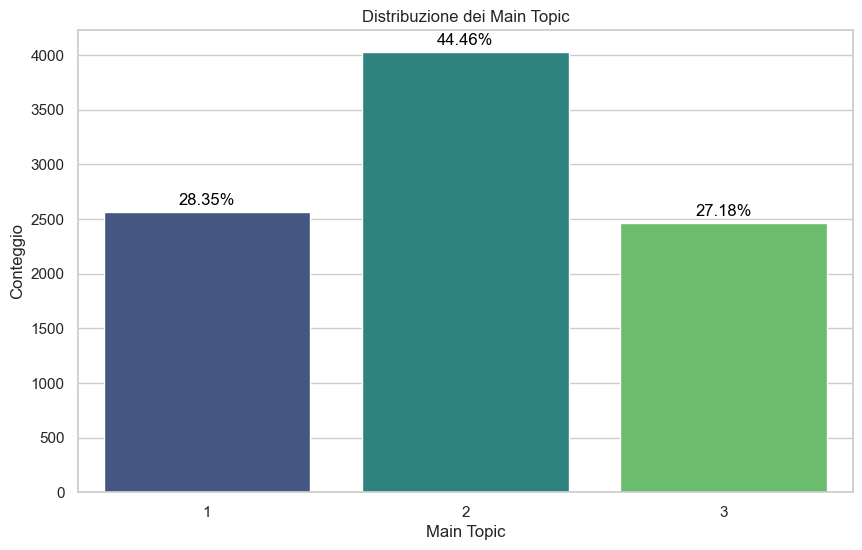

In [16]:
# Calculating percentages of topics
topic_counts = df_news['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

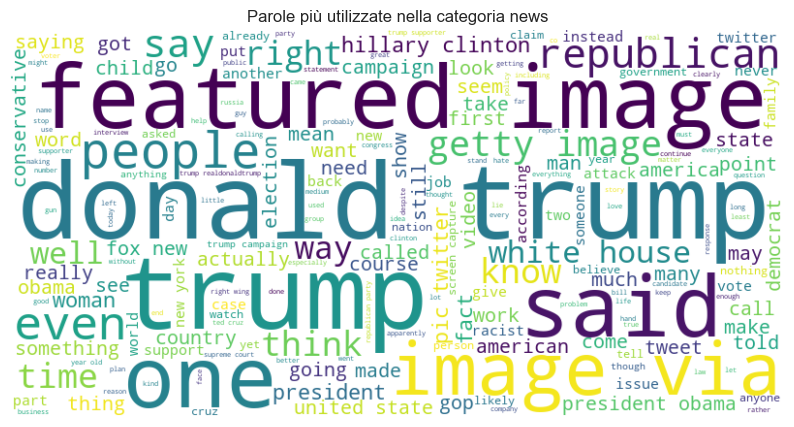

In [17]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_news['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria news')
plt.show()

Osservando il wordclous della categoria notizie generali possiamo osservare come possiamo trovare diversi riferimenti che vanno dalla politica alla citazione di personaggi di spicco come gli ex presidenti Donald Trump e Obama, vengono anche citate immagini correlate il che può significare che molte volte le fake news vengono accompagnate da immagini che mirano a far credere il lettore che si tratta invece di notizie veritiere

# Argomenti più sogetti alle fake news nella categoria politics

In [18]:
# Creation of the dataframe by categories
df_politics = df_fake_topic[df_fake_topic['subject'] == 'politics']
df_politics = df_politics[['document', 'subject']]
df_politics.head()

,document,subject
9050,Democrat Senator Warns Mueller Not To Release ...,politics
9051,MSNBC ANCHOR Flabbergasted at What Texas Teach...,politics
9052,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,politics
9053,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,politics
9054,DOJ’s JEFF SESSIONS Opens Investigation Into W...,politics


In [19]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_politics['tokens'] = df_politics['document'].apply(preprocess_text)

In [20]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_politics['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_politics['tokens']]

In [21]:
# Application of ldaModel
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)


In [22]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.011*"trump" + 0.006*"said" + 0.006*"president" + 0.005*"obama" + 0.005*"video" + 0.004*"year" + 0.004*"people" + 0.004*"hillary" + 0.004*"one" + 0.004*"state"
Topic 2: 0.012*"trump" + 0.006*"said" + 0.006*"one" + 0.005*"president" + 0.005*"clinton" + 0.004*"state" + 0.004*"obama" + 0.004*"people" + 0.004*"american" + 0.004*"video"
Topic 3: 0.010*"trump" + 0.008*"said" + 0.007*"clinton" + 0.006*"hillary" + 0.006*"president" + 0.005*"state" + 0.004*"obama" + 0.004*"people" + 0.004*"american" + 0.004*"would"


In [23]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_politics['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.287940215132355
Perplexity Score: 0.00020491705872318256


In [24]:
# Assignment of topics
df_politics['main_topic'] = df_politics['document'].apply(assign_topic)
df_politics.head()

,document,subject,tokens,main_topic
9050,Democrat Senator Warns Mueller Not To Release ...,politics,"[democrat, senator, warns, mueller, release, f...",1
9051,MSNBC ANCHOR Flabbergasted at What Texas Teach...,politics,"[msnbc, anchor, flabbergasted, texas, teacher,...",1
9052,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,politics,"[watch, snowflake, asked, communist, party, pl...",3
9053,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,politics,"[badass, general, john, kelly, shoved, chinese...",2
9054,DOJ’s JEFF SESSIONS Opens Investigation Into W...,politics,"[doj, jeff, session, open, investigation, fbi,...",2


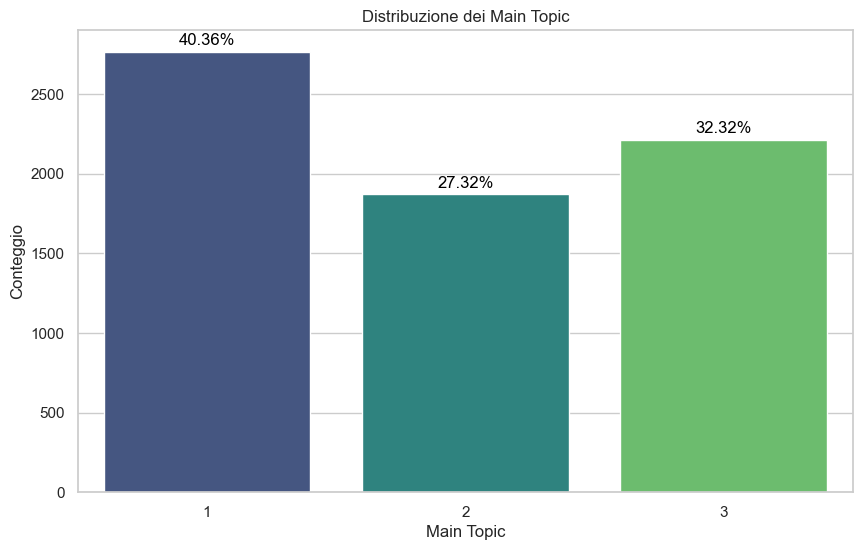

In [25]:
# Calculating percentages of topics
topic_counts = df_politics['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

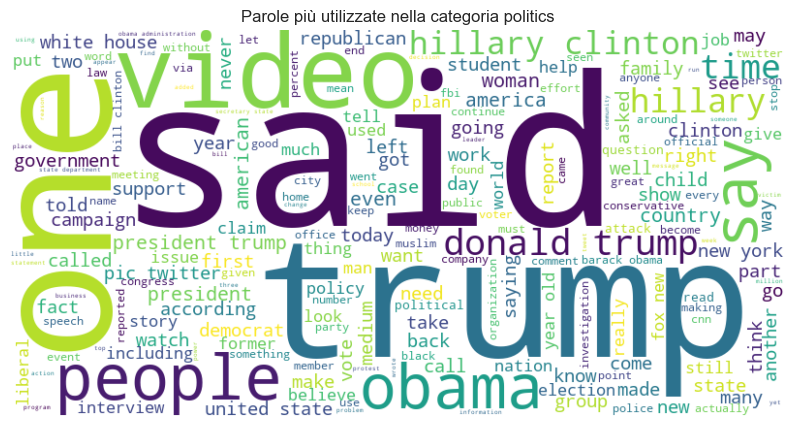

In [26]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_politics['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria politics')
plt.show()

Dal grafico delle wordcloud della categoria Politics possiamo trovare molti più riferimenti alla politica Americana. Troviamo l'ex presidente Trump e altre figure della politica statuintense come Hilary Clinton, ma anche le parole corrrelate come destra, sinistra, liberale, democratico ecc..
Il numero uno "one" in bella vista immagino sia ripetuto molte volte perchè può essere utilizzato per riferirsi al numero uno dell'america (il presidente) o magari in riferimento all'aereo che trasporta il presidente americano, l'air force ONE.

# Argomenti più sogetti alle fake news nella categoria left-news

In [27]:
#creation of the dataframe by categories
df_left_news = df_fake_topic[df_fake_topic['subject'] == 'left-news']
df_left_news = df_left_news[['document', 'subject']]

df_left_news.head()

,document,subject
17461,BARBRA STREISAND Gives Up On Dream Of Impeachi...,left-news
17462,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,left-news
17463,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...,left-news
17464,WHITE COLLEGE SNOWFLAKES Can ‘Identify’ As Bla...,left-news
17465,BILL NYE The FAKE Science Guy THREATENS Conser...,left-news


In [28]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_left_news['tokens'] = df_left_news['document'].apply(preprocess_text)

In [29]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_left_news['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_left_news['tokens']]

In [30]:
# Application of ldaModel
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)

In [31]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.010*"trump" + 0.009*"said" + 0.005*"clinton" + 0.004*"people" + 0.004*"president" + 0.004*"would" + 0.004*"black" + 0.003*"year" + 0.003*"one" + 0.003*"news"
Topic 2: 0.008*"trump" + 0.007*"president" + 0.005*"one" + 0.004*"said" + 0.004*"police" + 0.004*"would" + 0.004*"video" + 0.004*"hillary" + 0.004*"obama" + 0.003*"people"
Topic 3: 0.008*"trump" + 0.006*"said" + 0.005*"obama" + 0.005*"state" + 0.005*"year" + 0.004*"people" + 0.004*"hillary" + 0.004*"one" + 0.004*"president" + 0.004*"american"


In [32]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_left_news['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.2741312836347751
Perplexity Score: 0.00019198605503528024


In [33]:
# Assignment of topics
df_left_news['main_topic'] = df_left_news['document'].apply(assign_topic)
df_left_news.head()

,document,subject,tokens,main_topic
17461,BARBRA STREISAND Gives Up On Dream Of Impeachi...,left-news,"[barbra, streisand, give, dream, impeaching, t...",2
17462,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,left-news,"[watch, senator, lindsey, graham, drop, bombsh...",2
17463,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...,left-news,"[conservative, gay, guy, blast, penny, aspen, ...",2
17464,WHITE COLLEGE SNOWFLAKES Can ‘Identify’ As Bla...,left-news,"[white, college, snowflake, identify, black, c...",1
17465,BILL NYE The FAKE Science Guy THREATENS Conser...,left-news,"[bill, nye, fake, science, guy, threatens, con...",1


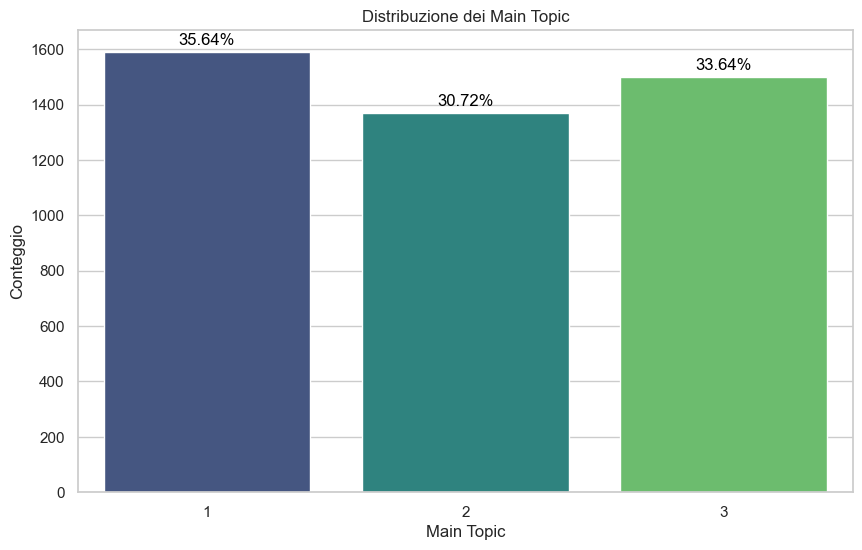

In [34]:
# Calculating percentages of topics
topic_counts = df_left_news['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

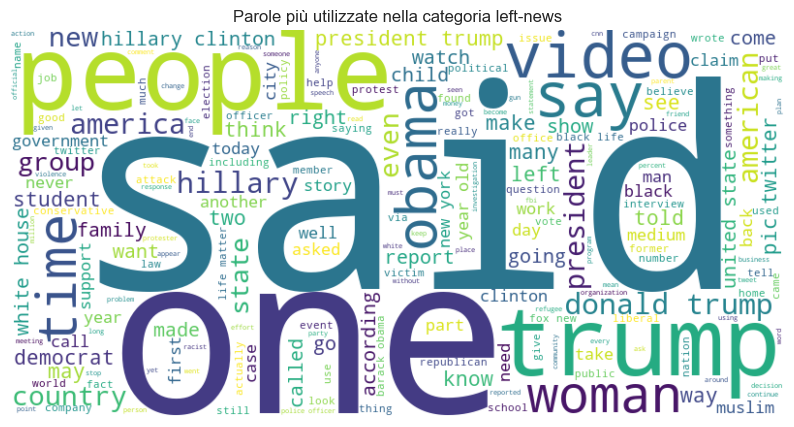

In [35]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_left_news['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria left-news')
plt.show()

Nel grafico delle wordcloud della categoria notizie di sinitra troviamo ancora esponenti di spicco della politica americana, ma possiamo anche osservare delle parole che magari possono ricondurre a campagne politiche realizzate dalla sinistra: People, Family, Officer, Woman, including

# Argomenti più sogetti alle fake news nella categoria government news

In [36]:
# Creation of the dataframe by categories
df_government_news = df_fake_topic[df_fake_topic['subject'] == 'Government News']
df_gobernment_news = df_government_news[['document', 'subject']]
df_government_news.head()

,subject,document
15891,Government News,TOP FIVE Food Stamp Fraud Takedowns of 2017…Do...
15892,Government News,HOUSE INTEL Slaps Subpoenas on McCain Institut...
15893,Government News,PRICELESS! WATCH MSNBC HOST’S Shocked Response...
15894,Government News,CBS HIT JOB On New Tax Bill Backfires When Acc...
15895,Government News,‘MORNING JOE’ PANEL Says Nikki Haley “Embarras...


In [37]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_government_news['tokens'] = df_government_news['document'].apply(preprocess_text)

C:\Users\Giacomo\AppData\Local\Temp\ipykernel_1124\3412241026.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_government_news['tokens'] = df_government_news['document'].apply(preprocess_text)


In [38]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_government_news['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_government_news['tokens']]

In [39]:
# Application of ldaModel
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)


In [40]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.007*"state" + 0.007*"said" + 0.006*"obama" + 0.005*"year" + 0.004*"one" + 0.004*"president" + 0.004*"people" + 0.004*"would" + 0.004*"american" + 0.003*"clinton"
Topic 2: 0.005*"state" + 0.005*"said" + 0.004*"american" + 0.004*"obama" + 0.004*"president" + 0.004*"year" + 0.004*"government" + 0.004*"people" + 0.004*"would" + 0.003*"clinton"
Topic 3: 0.010*"said" + 0.008*"obama" + 0.006*"state" + 0.005*"president" + 0.004*"trump" + 0.004*"would" + 0.004*"one" + 0.004*"clinton" + 0.004*"year" + 0.004*"american"


In [41]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_government_news['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.2553266512233899
Perplexity Score: 0.00019893525088029337


In [42]:
# Assignment of topics
df_government_news['main_topic'] = df_government_news['document'].apply(assign_topic)
df_government_news.head()

C:\Users\Giacomo\AppData\Local\Temp\ipykernel_1124\3475668286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_government_news['main_topic'] = df_government_news['document'].apply(assign_topic)


,subject,document,tokens,main_topic
15891,Government News,TOP FIVE Food Stamp Fraud Takedowns of 2017…Do...,"[top, five, food, stamp, fraud, takedown, see,...",2
15892,Government News,HOUSE INTEL Slaps Subpoenas on McCain Institut...,"[house, intel, slap, subpoena, mccain, institu...",2
15893,Government News,PRICELESS! WATCH MSNBC HOST’S Shocked Response...,"[priceless, watch, msnbc, host, shocked, respo...",1
15894,Government News,CBS HIT JOB On New Tax Bill Backfires When Acc...,"[cbs, hit, job, new, tax, bill, backfire, acco...",1
15895,Government News,‘MORNING JOE’ PANEL Says Nikki Haley “Embarras...,"[morning, joe, panel, say, nikki, haley, embar...",1


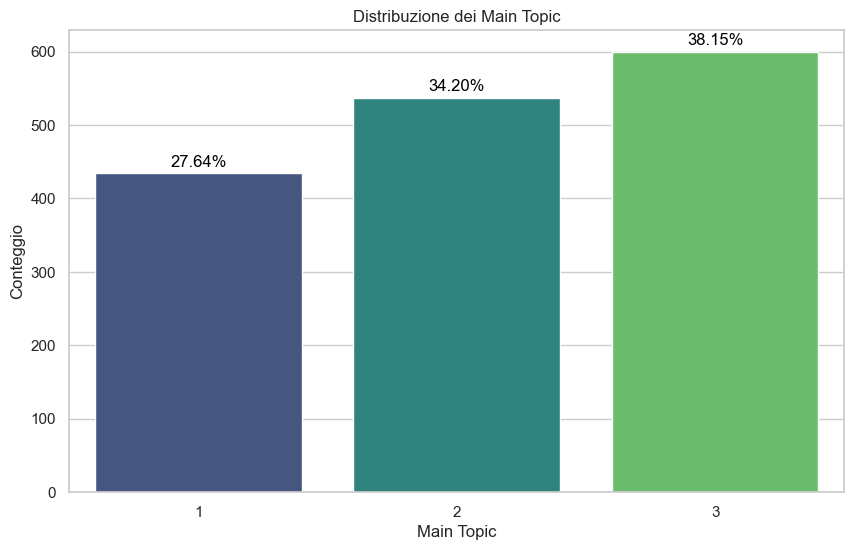

In [43]:
# Calculating percentages of topics
topic_counts = df_government_news['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

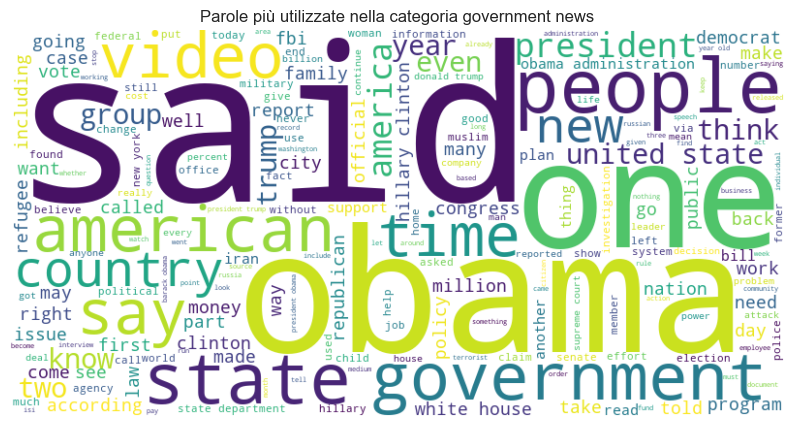

In [44]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_government_news['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria government news')
plt.show()

Nel grafico delle wordcloud delle notizie di governo troviamo riferimenti al governo americano, possiamo infatti osservare in primo piano la parola Government ma anche parole che possono ricondurre a notizie riguardanti il governo dell'America: Country, State, United State, White House


# Argomenti più sogetti alle fake news nella categoria us news

In [45]:
# creation of the dataframe by categories
df_us_news = df_fake_topic[df_fake_topic['subject'] == 'US_News']
df_us_news = df_us_news[['document', 'subject']]
df_us_news.head()

,document,subject
21920,YEAR IN REVIEW: 2017 Top Ten Conspiracies Patr...,US_News
21921,‘Classified’ Emails from Hillary Clinton and H...,US_News
21922,How Trump is Accelerating the Decline of US Gl...,US_News
21923,US Advising Soldiers to Be ‘Less Masculine’ as...,US_News
21924,"Dopey Santas, McAfee Hacked, Silicon Valley vs...",US_News


In [46]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_us_news['tokens'] = df_us_news['document'].apply(preprocess_text)

In [47]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_us_news['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_us_news['tokens']]

In [48]:
# Application of ldaModel
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1, chunksize=10000)


In [49]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.005*"medium" + 0.005*"trump" + 0.005*"state" + 0.004*"one" + 0.004*"news" + 0.004*"government" + 0.003*"new" + 0.003*"would" + 0.003*"also" + 0.003*"said"
Topic 2: 0.007*"trump" + 0.005*"medium" + 0.005*"clinton" + 0.004*"president" + 0.004*"syria" + 0.004*"news" + 0.004*"story" + 0.003*"one" + 0.003*"time" + 0.003*"new"
Topic 3: 0.007*"trump" + 0.005*"medium" + 0.005*"news" + 0.005*"state" + 0.004*"century" + 0.004*"also" + 0.003*"syria" + 0.003*"time" + 0.003*"wire" + 0.003*"new"


In [50]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_us_news['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.2886787870243645
Perplexity Score: 0.0001866251578489978


In [51]:
# Assignment of topics
df_us_news['main_topic'] = df_us_news['document'].apply(assign_topic)
df_us_news.head()

,document,subject,tokens,main_topic
21920,YEAR IN REVIEW: 2017 Top Ten Conspiracies Patr...,US_News,"[year, review, top, ten, conspiracy, patrick, ...",2
21921,‘Classified’ Emails from Hillary Clinton and H...,US_News,"[classified, email, hillary, clinton, huma, ab...",2
21922,How Trump is Accelerating the Decline of US Gl...,US_News,"[trump, accelerating, decline, global, influen...",2
21923,US Advising Soldiers to Be ‘Less Masculine’ as...,US_News,"[advising, soldier, le, masculine, military, t...",1
21924,"Dopey Santas, McAfee Hacked, Silicon Valley vs...",US_News,"[dopey, santa, mcafee, hacked, silicon, valley...",3


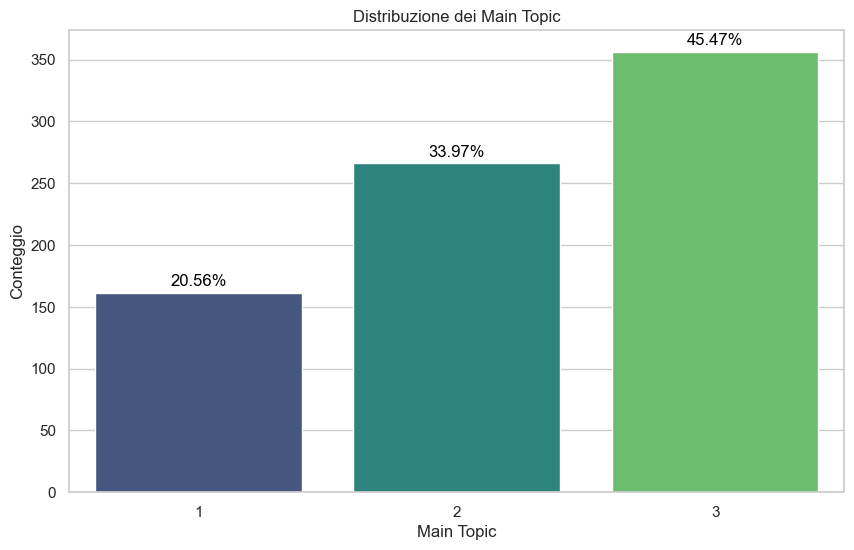

In [52]:
# Calculating percentages of topics
topic_counts = df_us_news['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

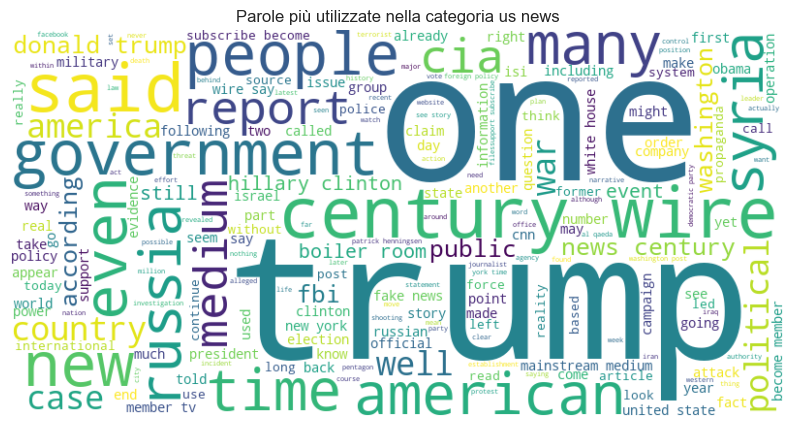

In [53]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_us_news['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria us news')
plt.show()

Nel grafico delle wordcloud riguardante le notizie che si riferiscono all'America troviamo una vastità di riferimenti sia politici (Trump, Government) sia internazionali (Russia, Syria, War)

# Argomenti più sogetti alle fake news nella categoria middle east

In [54]:
# Creation of the dataframe by categories
df_middle_east = df_fake_topic[df_fake_topic['subject'] == 'Middle-east']
df_middle_east = df_middle_east[['document', 'subject']]
df_middle_east.head()

,document,subject
22703,YEAR IN REVIEW: 2017 Top Ten Conspiracies Patr...,Middle-east
22704,‘Classified’ Emails from Hillary Clinton and H...,Middle-east
22705,How Trump is Accelerating the Decline of US Gl...,Middle-east
22706,US Advising Soldiers to Be ‘Less Masculine’ as...,Middle-east
22707,"Dopey Santas, McAfee Hacked, Silicon Valley vs...",Middle-east


In [55]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_middle_east['tokens'] = df_middle_east['document'].apply(preprocess_text)

In [56]:
# Creation of dictionary and corpus
dictionary = corpora.Dictionary(df_middle_east['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_middle_east['tokens']]

In [57]:
# Application of ldaModel
num_topics = 4
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1,chunksize=10000)

In [58]:
# Topic visualization
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Topic 1: 0.007*"trump" + 0.005*"medium" + 0.004*"state" + 0.004*"clinton" + 0.004*"century" + 0.003*"political" + 0.003*"one" + 0.003*"would" + 0.003*"syria" + 0.003*"election"
Topic 2: 0.007*"trump" + 0.004*"medium" + 0.004*"state" + 0.004*"also" + 0.004*"news" + 0.003*"one" + 0.003*"president" + 0.003*"political" + 0.003*"election" + 0.003*"clinton"
Topic 3: 0.007*"medium" + 0.004*"trump" + 0.004*"news" + 0.004*"time" + 0.004*"said" + 0.003*"new" + 0.003*"one" + 0.003*"story" + 0.003*"state" + 0.003*"syria"
Topic 4: 0.008*"trump" + 0.005*"news" + 0.005*"state" + 0.005*"clinton" + 0.004*"medium" + 0.004*"new" + 0.004*"one" + 0.004*"government" + 0.004*"century" + 0.004*"would"


In [59]:
# Coherence  and perplexity Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_middle_east['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(log_perplexity)

print(f"Coherence Score: {coherence_lda}")
print(f"Perplexity Score: {perplexity}")

Coherence Score: 0.2891024332388059
Perplexity Score: 0.00017795645170207608


In [60]:
# Assignment of topics
df_middle_east['main_topic'] = df_middle_east['document'].apply(assign_topic)
df_middle_east.head()

,document,subject,tokens,main_topic
22703,YEAR IN REVIEW: 2017 Top Ten Conspiracies Patr...,Middle-east,"[year, review, top, ten, conspiracy, patrick, ...",3
22704,‘Classified’ Emails from Hillary Clinton and H...,Middle-east,"[classified, email, hillary, clinton, huma, ab...",4
22705,How Trump is Accelerating the Decline of US Gl...,Middle-east,"[trump, accelerating, decline, global, influen...",4
22706,US Advising Soldiers to Be ‘Less Masculine’ as...,Middle-east,"[advising, soldier, le, masculine, military, t...",3
22707,"Dopey Santas, McAfee Hacked, Silicon Valley vs...",Middle-east,"[dopey, santa, mcafee, hacked, silicon, valley...",3


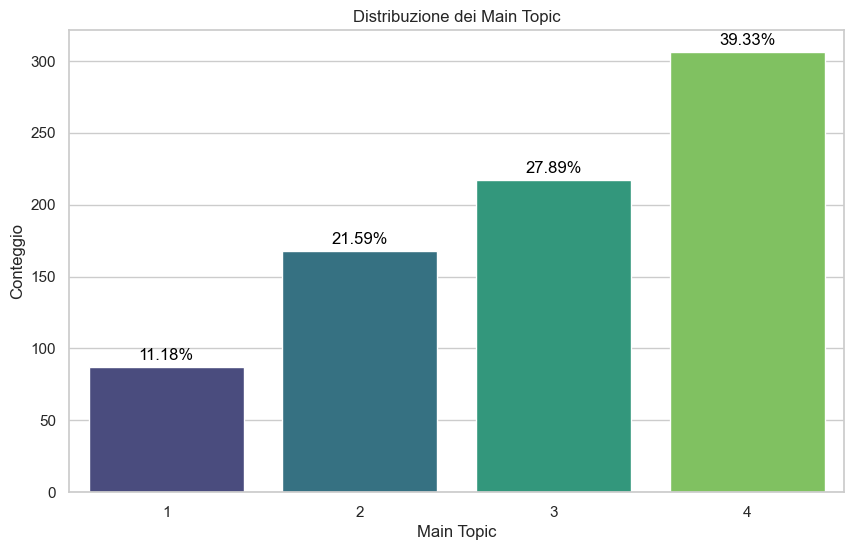

In [61]:
# Calculating percentages of topics
topic_counts = df_middle_east['main_topic'].value_counts().sort_index()
topic_percentages = (topic_counts / topic_counts.sum()) * 100

df_plot = pd.DataFrame({
    'Topic': topic_counts.index,
    'Count': topic_counts.values,
    'Percentage': topic_percentages.values
})

# Creation of bar chart with percentages of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Count', data=df_plot, palette='viridis')

for index, row in df_plot.iterrows():
    plt.annotate(f"{row['Percentage']:.2f}%", 
                 xy=(row.name, row['Count']), 
                 xytext=(0, 5), 
                 textcoords='offset points', 
                 ha='center', 
                 color='black')

plt.title('Distribuzione dei Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Conteggio')
plt.show()

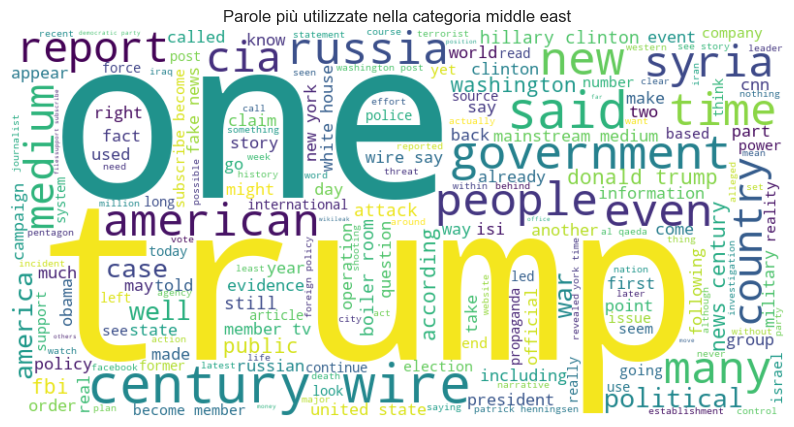

In [62]:
# Creation of word cloud
all_tokens = []
for tokens_list in df_middle_east['tokens']:
    all_tokens.extend(tokens_list)

wordcloud_text = ' '.join(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Parole più utilizzate nella categoria middle east')
plt.show()

Nel grafico delle wordcloud della categoria medio oriente possiamo osservare molte parole che ci riconducono alle situazioni difficili in medio oriente: si parla di Russia, Syria, Israele ma possiamo trovare anche parole che riconducono alla guerdda come: War, Military, Attack, Operation.

## I TITOLI DELLE FAKE NEWS PRESENTANO DEI PATTERN?

In [63]:
# Select only the 'title' column from the dataframe
df_fake_title = df_fake[['title']]

# Display a random sample of 10 rows from the 'title' column
df_fake_title.sample(10)

,title
18013,LEFTIST ACTRESS ALYSSA MILANO Gets BLASTED On ...
19556,WHY IS JILL STEIN Demanding A Recount? Is Hill...
6492,Bill Maher Shows America Why Donald Trump Mus...
11761,BUDWEISER Unveils SUPER BOWL Ad That Distorts ...
3827,REPORT: Civil Rights Groups Say Voter Suppres...
7721,Republicans Hold CPAC Event In A Gun Free Zon...
17016,DEAR MR PRESIDENT: Listen To Your Own FBI Dire...
21868,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...
18428,#VeryFakeNews CNN BRAGS ABOUT RATINGS To Presi...
6589,Watch Ted Cruz’s Disturbing Reaction When Car...


In [64]:
# Function to tokenize and do POS tagging
def get_pos_counts(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    pos_counts = Counter(tag for word, tag in pos_tags)
    return pos_counts

# Apply the function to each row of the dataframe and aggregate the results
pos_counts_list = df_fake_title['title'].apply(get_pos_counts)
total_pos_counts = sum(pos_counts_list, Counter())


In [65]:
# Sort the results in descending order
sorted_pos_counts = sorted(total_pos_counts.items(), key=lambda item: item[1], reverse=True)

# View sorted results
sorted_pos_counts

[('NNP', 254681),
 ('IN', 29434),
 ('NN', 19166),
 ('JJ', 10550),
 ('DT', 9381),
 ('TO', 8775),
 (':', 8673),
 ('VBD', 7375),
 ('VBZ', 6703),
 ('PRP', 6629),
 ('VB', 6485),
 ('.', 5932),
 ('NNS', 5075),
 ('VBG', 4522),
 (',', 4492),
 ('(', 4131),
 (')', 4131),
 ('VBP', 3862),
 ('RB', 3795),
 ('CD', 3655),
 ('CC', 3637),
 ('NNPS', 2722),
 ('PRP$', 2655),
 ('VBN', 1566),
 ('WRB', 1524),
 ('WP', 944),
 ('MD', 924),
 ('#', 805),
 ('RP', 736),
 ('$', 517),
 ('JJR', 343),
 ('WDT', 265),
 ('JJS', 187),
 ('EX', 170),
 ('POS', 127),
 ('UH', 97),
 ('PDT', 97),
 ('RBR', 93),
 ('FW', 71),
 ('RBS', 57),
 ("''", 27)]

Dal POS tagging possiamo osservare che i tag più frequenti sono: NNP (Nome proprio), IN (Preposizione o congiunzione subordinata), NN (Nome comune), JJ (Aggettivo) e DT (Determinante). Questa distribuzione è significativa e evidenza alcune caratteristiche dei testi analizzati.

In primo luogo, l'alta frequenza di NNP (Nome proprio) è attribuibile al fatto che molte delle notizie trattano di politica americana, spesso citando nomi di persone, luoghi, organizzazioni e altri enti specifici. In particolare, vengono menzionati numerosi presidenti ed ex presidenti, oltre a figure politiche di rilievo, il che spiega la predominanza di nomi propri nel corpus.

In secondo luogo, la frequenza elevata di IN (Preposizione o congiunzione subordinata) indica una complessità sintattica nei testi, con numerose frasi subordinate che forniscono dettagli aggiuntivi e contesto. Questo tipo di struttura è comune negli articoli di notizie, dove è importante collegare informazioni e situazioni in modo chiaro e preciso.

La presenza significativa di NN (Nome comune) e JJ (Aggettivo) è anch'essa caratteristica dei testi giornalistici. I nomi comuni sono essenziali per identificare oggetti, concetti e fenomeni di interesse generale, mentre gli aggettivi sono frequentemente utilizzati per descrivere e qualificare i nomi, contribuendo a creare immagini vivide e ad evocare emozioni nel lettore. Gli aggettivi giocano un ruolo cruciale nel rendere le notizie più coinvolgenti e nell'attirare l'attenzione del pubblico.

Infine, l'uso frequente di DT (Determinante) evidenzia la struttura grammaticale dei titoli e dei testi, dove i determinanti sono utilizzati per specificare i nomi, rendendo le frasi più comprensibili e definite. I determinanti come "the", "a", e "an" sono fondamentali per costruire frasi grammaticalmente corrette e per guidare il lettore nella comprensione del testo.

In sintesi, l'analisi dei tag POS nei testi giornalistici rivela non solo le caratteristiche linguistiche dei contenuti, ma anche le strategie utilizzate dagli autori per comunicare efficacemente con i lettori, fornendo informazioni precise e creando un impatto emotivo attraverso una descrizione dettagliata e coinvolgente.

## CREAZIONE DEL MODELLO PER IDENTIFICARE LE FAKE NEWS

In [66]:
df_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [67]:
# Combine 'title' and 'text' columns into a new column named 'document' with a space in between.
df_true['document'] = df_true['title'] + " " + df_true['text']

# Keep only the 'document' column in the DataFrame.
df_true = df_true[['document']]

# Assign a new column named 'label' with value 0 to indicate that the documents in this DataFrame are true.
df_true["label"] = 0

# Return the cleaned DataFrame.
df_true

C:\Users\Giacomo\AppData\Local\Temp\ipykernel_1124\3395422838.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true["label"] = 0


,document,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorit...,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [68]:
# Combine 'title' and 'text' columns into a new column named 'document' with a space in between.
df_fake['document'] = df_fake['title'] + " " + df_fake['text']

# Keep only the 'document' column in the DataFrame.
df_fake = df_fake[['document']]

# Assign a new column named 'label' with value 0 to indicate that the documents in this DataFrame are true.
df_fake["label"] = 1

# Return the cleaned DataFrame.
df_fake

,document,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [69]:
# Add a 'label' column to distinguish between true news (1) and false news (0).
# Create a copy of the cleaned true news DataFrame and add a 'label' column with value 0.
df_true_label = df_true.copy()
df_true_label['label'] = 0

# Create a copy of the cleaned fake news DataFrame and add a 'label' column with value 1.
df_fake_label = df_fake.copy()
df_fake_label['label'] = 1

# Concatenate the true and fake news DataFrames into one DataFrame.
df_full = pd.concat([df_true_label, df_fake_label])

# Sample 15 rows from the merged DataFrame to display.
df_full.sample(15)

,document,label
17447,Raqqa evacuation included some foreign fighter...,0
8171,Lawmakers aim to delay U.S. ceding control of ...,0
14414,Pinera leads Chile election with 36 percent af...,0
19601,TRUMP PROTEST ORGANIZER Destroyed In Debate On...,1
17927,‘Die Hard’ Lion’s Fan Gives Best Ever #Boycott...,1
17911,Iran has 'all options on table' if U.S. blackl...,0
20676,Venezuelan bishops tell pope of 'truly despera...,0
18680,AFTER 5 YEARS Of Being Bullied By Barack Obama...,1
20356,"New Zealand Labour still wants TPP part, but o...",0
19375,LIBERALS SEE THE LIGHT! HuffPo Columnist LETS ...,1


In [70]:
# Preprocessing: cleaning and tokenization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Convertire il testo in minuscolo
    text = text.lower()
    # Rimuovere la punteggiatura
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizzare il testo
    tokens = word_tokenize(text)
    # Rimuovere le stopwords e lemmatizzare i token
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df_full['cleaned_text'] = df_full['document'].apply(preprocess_text)

In [71]:
# Vectorize the text with TfidVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_full['cleaned_text'])
y = df_full['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [73]:
# Make predictions on test data
y_pred = model.predict(X_test)

## VALUTAZIONE DEL MODELLO

In [74]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.9874164810690423
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4330
           1       0.99      0.99      0.99      4650

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



I risultati della valutazione del modello sono estremamente positivi, evidenziando un'elevata performance complessiva:

Accuracy: 0.9874. Questo indica che il modello ha classificato correttamente il 98.74% dei campioni nel dataset di test. Un'accuratezza così alta suggerisce che il modello è molto efficace nel distinguere tra le due classi.

Classification Report:
- Classe 0:
Precisione: 0.98. Il 98% delle istanze classificate come appartenenti alla classe 0 sono effettivamente corrette.
Recall: 0.99. Il modello ha identificato correttamente il 99% delle istanze della classe 0.
F1-Score: 0.99. La combinazione armonica di precisione e recall indica un eccellente equilibrio tra i due.
- Classe 1:
Precisione: 0.99. Il 99% delle istanze classificate come appartenenti alla classe 1 sono effettivamente corrette.
Recall: 0.99. Il modello ha identificato correttamente il 99% delle istanze della classe 1.
F1-Score: 0.99. Anche qui, l'equilibrio tra precisione e recall è ottimale.
- Macro Avg: La media delle metriche per entrambe le classi è 0.99, indicando che il modello è bilanciato e performante per entrambe le classi.

- Weighted Avg: Anche questa media ponderata delle metriche è 0.99, confermando che la performance del modello è consistente, considerando il numero di campioni per ciascuna classe.

In sintesi, il modello dimostra un'eccellente capacità di classificazione, con alte prestazioni in termini di precisione, recall e f1-score per entrambe le classi. La sua accuratezza complessiva del 98.74% suggerisce che il modello è altamente affidabile e ben addestrato per il compito di classificazione assegnato.

## ESPORTAZIONE DEL MODELLO

In [75]:
# Serialize and save the svm_model object using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)